<a href="https://colab.research.google.com/github/nasirbashak/Plant-the-future/blob/master/LSTM_Bidirectional_model_for_Traffic_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install tensorflow==2.0.0b1
!pip install tensorflow==2.1.0

In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print(tf.__version__)

2.1.0


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

#normalizing data
# Z-Score scaling or Standard Scaling
# Output range [-3 to +3]
def norm(x):
  return (x - x.mean()) / x.std(), x.mean(), x.std()

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(3).prefetch(1)
    forecast = model.predict(ds)
    return forecast



In [31]:
df = pd.read_csv('TrafficDensity2000to2019.csv')
df.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,18018,43257,4364,9948,15486,10824,11394,62040,139362,222630,252997,275822,341228,418053,456370,458760,436913,383336,366666,360215
1,199759,206274,197413,224211,246554,253461,268019,285571,321176,305794,302507,306456,316183,312025,321552,304690,347855,351027,402511,430174
2,31975,18508,50090,33138,3230,40469,77694,91859,95982,68764,32090,3793,36285,51176,27385,645,20132,61869,123441,138125
3,143344,202934,239277,261303,290123,294132,292993,300010,288019,267043,214461,176663,106045,39201,64827,111801,180004,222712,251049,263517
4,13344,132736,256770,326341,373479,400300,339817,354813,290336,246211,191379,169207,44706,96832,217791,297401,378743,428859,435385,477570


In [32]:
time = np.array(range(len(df.columns)))
print(time[:],time.shape)
series = np.array(df.iloc[10,:])
print(series[:10],series.shape)



[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] (20,)
[ 84621  21015  24739  67879 146544 186156 259504 242919 228264 243974] (20,)


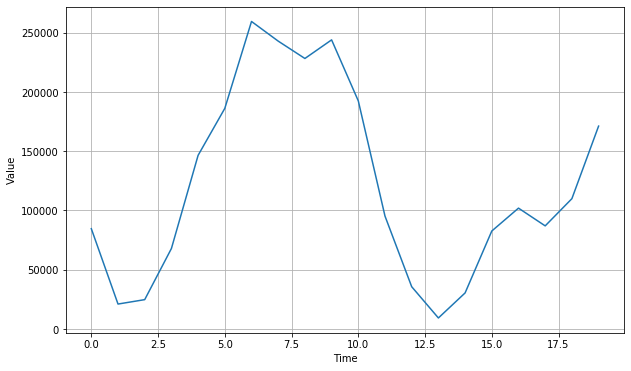

In [33]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 20
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 3
batch_size = 3
shuffle_buffer_size = 10



In [0]:
  
normed_train_data, normed_train_mean, normed_train_std = norm(x_train)
normed_valid_data, normed_valid_mean, normed_valid_std = norm(x_valid)

In [36]:
normed_train_data

array([-0.4549311 , -1.24888234, -1.20239814, -0.66391031,  0.31801239,
        0.81246255,  1.72801668,  1.5209972 ,  1.33806861,  1.53416606,
        0.8912011 , -0.32253099, -1.06625334, -1.39556224, -1.1317731 ,
       -0.47959618, -0.23847497, -0.42534797, -0.13877857,  0.62551465])

In [37]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 3
batch_size = 3
train_set = windowed_dataset(normed_train_data, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(normed_train_data.shape)

model = tf.keras.models.Sequential([
  #tf.keras.layers.Conv1D(filters=3, kernel_size=2,strides=1, padding="causal",activation="relu",input_shape=[None, 1]),
  
  tf.keras.layers.LSTM(3, return_sequences=True,input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6, return_sequences=False)),
  #tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(20,)
Epoch 1/100
6/6 [==============================] - 8s 1s/step - loss: 1.3314 - mae: 1.7790
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 1.2831 - mae: 1.7748
Epoch 3/100
6/6 [==============================] - 0s 9ms/step - loss: 1.2961 - mae: 1.7680
Epoch 4/100
6/6 [==============================] - 0s 8ms/step - loss: 1.2458 - mae: 1.7594
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 1.3039 - mae: 1.7481
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 1.2265 - mae: 1.7358
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 1.2618 - mae: 1.7224
Epoch 8/100
6/6 [==============================] - 0s 9ms/step - loss: 1.2247 - mae: 1.7065
Epoch 9/100
6/6 [==============================] - 0s 9ms/step - loss: 1.2363 - mae: 1.6881
Epoch 10/100
6/6 [==============================] - 0s 9ms/step - loss: 1

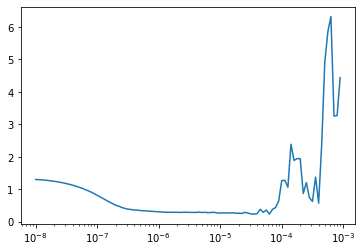

In [38]:
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-3, 100000, 140000])

In [39]:
bestLr = history.history["lr"][np.argmin(history.history["loss"])]
bestLr

3.548134e-05

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(normed_train_data, window_size=3, batch_size=3, shuffle_buffer=shuffle_buffer_size)


model = tf.keras.models.Sequential([
  #tf.keras.layers.Conv1D(filters=60, kernel_size=5,strides=1, padding="causal",activation="relu",input_shape=[None, 1]),
  #tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(3, return_sequences=True,input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6, return_sequences=False)),
  #tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])


optimizer = tf.keras.optimizers.SGD(lr=bestLr, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 3)           60        
_________________________________________________________________
bidirectional (Bidirectional (None, 12)                480       
_________________________________________________________________
dense (Dense)                (None, 10)                130       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 681
Trainable params: 681
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model.fit(train_set,epochs=250)

Epoch 1/250
6/6 [==============================] - 3s 454ms/step - loss: 0.6306 - mae: 1.0201
Epoch 2/250
6/6 [==============================] - 0s 9ms/step - loss: 0.4343 - mae: 0.7967
Epoch 3/250
6/6 [==============================] - 0s 9ms/step - loss: 0.4319 - mae: 0.8026
Epoch 4/250
6/6 [==============================] - 0s 9ms/step - loss: 0.4621 - mae: 0.8252
Epoch 5/250
6/6 [==============================] - 0s 10ms/step - loss: 0.3991 - mae: 0.8002
Epoch 6/250
6/6 [==============================] - 0s 10ms/step - loss: 0.5707 - mae: 0.9645
Epoch 7/250
6/6 [==============================] - 0s 10ms/step - loss: 0.5567 - mae: 0.9804
Epoch 8/250
6/6 [==============================] - 0s 10ms/step - loss: 0.2947 - mae: 0.6058
Epoch 9/250
6/6 [==============================] - 0s 9ms/step - loss: 0.3485 - mae: 0.6915
Epoch 10/250
6/6 [==============================] - 0s 9ms/step - loss: 0.2827 - mae: 0.6369
Epoch 11/250
6/6 [==============================] - 0s 9ms/step - loss: 0

In [43]:

norm_series_data, norm_series_mean, norm_series_std = norm(series)
norm_series_data

array([-0.4549311 , -1.24888234, -1.20239814, -0.66391031,  0.31801239,
        0.81246255,  1.72801668,  1.5209972 ,  1.33806861,  1.53416606,
        0.8912011 , -0.32253099, -1.06625334, -1.39556224, -1.1317731 ,
       -0.47959618, -0.23847497, -0.42534797, -0.13877857,  0.62551465])

In [44]:
rnn_forecast = model_forecast(model, norm_series_data[..., np.newaxis], window_size)
print(rnn_forecast.shape)
rnn_forecast = rnn_forecast[ 0:-1, -1]
#rnn_forecast = rnn_forecast[:-1, -1]
print(rnn_forecast.shape)

rnn_forecast

(18, 1)
(17,)


array([-0.61522406, -0.4113054 ,  0.38531062,  1.2181606 ,  1.254656  ,
        1.4426787 ,  1.4334178 ,  1.4016731 ,  1.262213  ,  0.83589184,
       -0.5882407 , -0.61859286, -0.66977704, -0.31083167,  0.14010763,
        0.19400467,  0.26763013], dtype=float32)

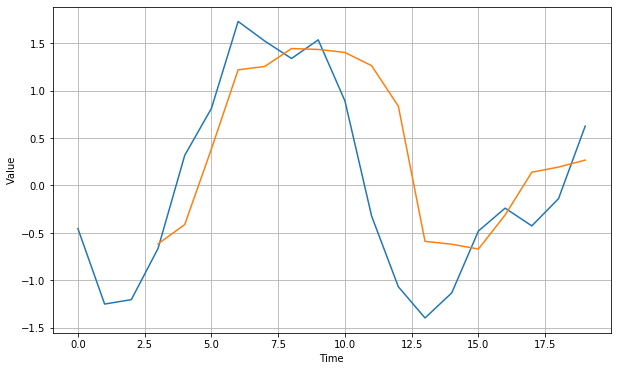

In [45]:
plt.figure(figsize=(10, 6))
plot_series(time_train, normed_train_data)
plot_series(time_train[3:], rnn_forecast)

In [46]:
tf.keras.metrics.mean_absolute_error(normed_train_data[3:], rnn_forecast).numpy()

0.5307785

In [47]:
print(rnn_forecast)

[-0.61522406 -0.4113054   0.38531062  1.2181606   1.254656    1.4426787
  1.4334178   1.4016731   1.262213    0.83589184 -0.5882407  -0.61859286
 -0.66977704 -0.31083167  0.14010763  0.19400467  0.26763013]


In [48]:
# x = y* Sigma + mean
print(norm_series_mean)
print(normed_train_mean)

original_series = rnn_forecast * normed_train_std+ normed_train_mean
print("Forecasted Series",original_series)
print("Series",x_train[3:])

121067.0
121067.0
Forecasted Series [ 71779.41   88116.    151935.48  218657.78  221581.55  236644.66
 235902.73  233359.56  222186.97  188033.     73941.14   71509.52
  67409.     96165.266 132291.47  136609.34  142507.72 ]
Series [ 67879 146544 186156 259504 242919 228264 243974 192464  95228  35646
   9264  30397  82645 101962  86991 109949 171179]


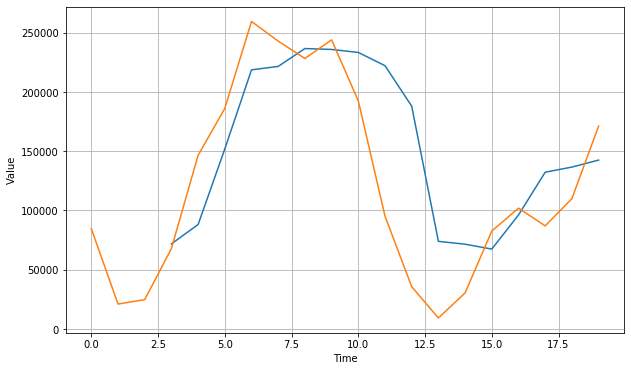

In [49]:
plt.figure(figsize=(10, 6))
plot_series(time_train[3:], original_series)
plot_series(time_train, series)

In [0]:
model.save("LSTM_Bidirectional_model.h5")

## Predictions using trained model

### Step 1: Importing libraries

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Step 1 : Load the dataset

In [51]:
try:
  df = pd.read_csv("TrafficDensity2000to2019.csv")
  print(df.head())
  print(df.tail())
except FileNotFoundError:
  print("Dataset File not found")
  

     2000    2001    2002    2003  ...    2016    2017    2018    2019
0   18018   43257    4364    9948  ...  436913  383336  366666  360215
1  199759  206274  197413  224211  ...  347855  351027  402511  430174
2   31975   18508   50090   33138  ...   20132   61869  123441  138125
3  143344  202934  239277  261303  ...  180004  222712  251049  263517
4   13344  132736  256770  326341  ...  378743  428859  435385  477570

[5 rows x 20 columns]
       2000    2001    2002    2003  ...    2016    2017    2018    2019
995  149254  154188  163279  170645  ...  259190  268790  278025  286573
996   38526  119449  198658  233426  ...  100550  164971  217201  236679
997   32279   14075   21236   34409  ...  198629  215467  248502  264773
998  180195  205710  288049  346179  ...  219080  190117  244531  290784
999   72669   49821   74458   39664  ...  286319  314117  277458  237214

[5 rows x 20 columns]


### Step 2 : Load the pre-trained model

In [0]:
try:
  model = tf.keras.models.load_model("LSTM_Bidirectional_model.h5")
except OSError:
  print("The model not found")

### Helper functions

In [0]:
#normalizing data
# Z-Score scaling or Standard Scaling
# Output range [-3 to +3]
def norm(x):
  return (x - x.mean()) / x.std(), x.mean(), x.std()

# Plotting the traffic data
def plot_series(time, series, format="-", start=0, end=None,save=False,name=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    if save:
      plt.savefig(name+".png")

# Preparing the data suitable for input of the model
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(3).prefetch(1)
    forecast = model.predict(ds)
    return forecast

# Predicting the traffic density in the given year
def predict(year,all=False):
  predictions = []
  norm_series_data_copy = np.copy(norm_series_data)

  if year <20:
    print("Year less than 20")
    return [norm_series_data_copy[year]* norm_series_std+ norm_series_mean]

  elif year >20:
    temp_year = 20
    while temp_year != year:
      #print("temp_year",temp_year)
      forecast = model_forecast(model, norm_series_data_copy[temp_year-window_size:temp_year][...,np.newaxis], window_size)
      #print("Value calculated for ",temp_year,forecast[0][-1]* norm_series_std+ norm_series_mean)
      norm_series_data_copy = np.append(norm_series_data_copy,forecast[0][-1])
      
      # Formula to calculate the original value from normalized output
      # x = y* Sigma + mean
      predictions.append(forecast[0][-1]* norm_series_std+ norm_series_mean)
      temp_year+=1
      
    forecast = model_forecast(model, norm_series_data_copy[year-window_size:year][...,np.newaxis], window_size)
    predictions.append(forecast[0][-1]* norm_series_std+ norm_series_mean)

  else:
    forecast = model_forecast(model, norm_series_data_copy[year-window_size:year][...,np.newaxis], window_size)
    predictions.append(forecast[0][-1]* norm_series_std+ norm_series_mean)

  if all:
    return predictions
  return [forecast[0][-1]* norm_series_std+ norm_series_mean]




### Step 3 : Predictions on model

Time Intervals : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Shape of Time Intervals : (20,)
Traffic Series Data : [ 84621  21015  24739  67879 146544 186156 259504 242919 228264 243974]
Shape of Traffic Series Data : (20,)
Normalized Series Data : [-0.4549311  -1.24888234 -1.20239814 -0.66391031  0.31801239  0.81246255
  1.72801668  1.5209972   1.33806861  1.53416606  0.8912011  -0.32253099
 -1.06625334 -1.39556224 -1.1317731  -0.47959618 -0.23847497 -0.42534797
 -0.13877857  0.62551465]
Normalized Series Mean : 121067.0
Normalized Series STD : 80113.23116751689


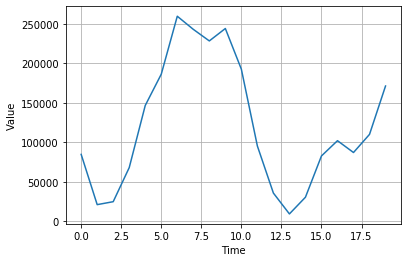

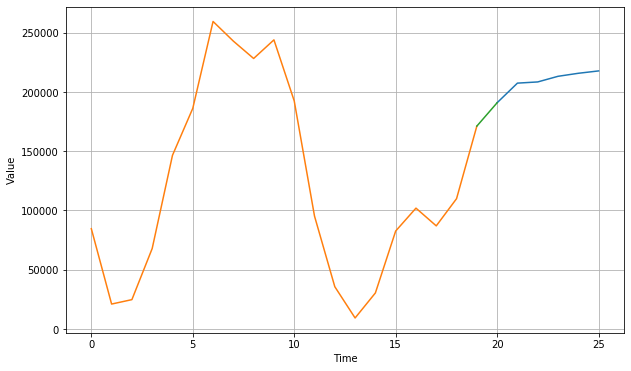

In [77]:
# select an area
area = 10

# select an year to forecast
year = 2025

#constant value don't change
window_size = 3

# time interval values which is equal to number of columns for now!!
time = np.array(range(len(df.columns)))
print("Time Intervals :",time[:])
print("Shape of Time Intervals :",time.shape)

# traffic density values of selected area
series = np.array(df.iloc[area,:])
print("Traffic Series Data :",series[:10])
print("Shape of Traffic Series Data :",series.shape)

# normalizing the series data
norm_series_data, norm_series_mean, norm_series_std = norm(series)
print("Normalized Series Data :",norm_series_data)
print("Normalized Series Mean :",norm_series_mean)
print("Normalized Series STD :",norm_series_std)


# visualizing the traffic data of the selected area
plot_series(time, series)

#Forecasting the traffic density
y = year % 2000
prediction = predict(y,True)

if len(prediction) > 1:
  years = list(range(20,y+1))
  plt.figure(figsize=(10, 6))
  plot_series(years,prediction,save=False,name="test")
  plot_series(time, series)
  plt.plot([time[-1],years[0]],[series[-1],prediction[0]])
  plt.savefig("Prediction.png")

else:
  print("The Forecasted traffic value of {} year is {}".format(year,int(prediction[0])))
  plt.figure(figsize=(10, 6))
  plot_series([y],prediction,format='*',save=False,name="test")
  plot_series(time, series)
  if y == 20:
    plt.plot([y],[prediction[0]])
  else:
    plt.plot([time[y],y],[series[y],prediction[0]])
  plt.savefig("Prediction.png")




